We want to format the folder for ALAMBIC and do some statistics on the number of sentences per paper, etc.

In [2]:
import pandas as pd
import matplotlib.pyplot as mpl
import seaborn as sns
import os
import json
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=min(os.cpu_count(), 12))

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
DATA_PATH = "data/tagged_text/"
OLIDA_PATH = "data/"

# Check the combinations are digenic

In [9]:
gene_combinations = pd.read_csv(f"{OLIDA_PATH}GeneCombination.tsv", sep="\t")
gene_combinations['list_genes'] = gene_combinations.Genes.str.split(';')
gene_combinations = gene_combinations[gene_combinations.list_genes.str.len() == 2]
digenic_combinations = gene_combinations['Oligogenic variant combinations'].str.split(';').explode().str.strip().to_list()

In [10]:
variant_combinations = pd.read_csv(f"{OLIDA_PATH}Combination.tsv", sep='\t')
variant_combinations = variant_combinations[variant_combinations['OLIDA ID'].isin(digenic_combinations)]
references_pmid = variant_combinations.References.str.split(';').explode().str.strip().unique().tolist()

In [11]:
references = pd.read_csv(f"{OLIDA_PATH}olida_reference.tsv", sep='\t')
digenic_references = references[references['Pubmed Id'].astype(str).isin(references_pmid)]
digenic_references = digenic_references['Pmc Id'].str.replace('PMC','').unique().tolist()

# Create the tables

In [7]:
alambic_table = pd.DataFrame(columns=['content', 'label', 'misc'])
stats = pd.DataFrame(columns=['pmcid','num_sentences', 'num_variants','num_genes','num_combinations_genes'])
for file in os.listdir(f"{DATA_PATH}"):
    if file.endswith('.tsv') and file not in ('alambic_table.tsv','stats_table.tsv') and file.replace('.tsv','') in digenic_references:
        table = pd.read_csv(f"{DATA_PATH}{file}", sep="\t")
        num_sentences = len(table)
        print(num_sentences, file)
        if num_sentences > 5000000:
            continue
        num_variants = len(set(table['variant1'].to_list()).union(set(table['variant2'].to_list())))
        num_genes = len(set(table['gene1'].to_list()).union(set(table['gene2'].to_list())))
        num_combinations_genes = len(table.groupby(['gene1','gene2']))
        stats = pd.concat([stats, pd.DataFrame({
            'pmcid' : [file.replace('.tsv','')],
            'num_sentences' : [num_sentences],
            'num_variants' : [num_variants],
            'num_genes' : [num_genes],
            'num_combinations_genes' : [num_combinations_genes]
        })])
        if len(table)> 0:
            table['misc'] = file.replace('.tsv','') + '/' + table.gene1 + '/' + table.gene2 + '/' + table.variant1 + '/' + table.variant2
            table.drop(columns=['gene1','gene2','variant1','variant2','pmcid'])
            table.rename(columns={'sentence':'content', 'misc': 'misc'})
            table['label'] = ''
            alambic_table = pd.concat([alambic_table,table]) 
        

4397 6057824.tsv
86640 3695851.tsv
15444 3975370.tsv
52030 7696449.tsv
87715 6098846.tsv
242705 5966321.tsv
899 5967407.tsv
66034 5887939.tsv
17029 5611365.tsv
742234 7067772.tsv
132565 6707335.tsv
107513 2737700.tsv
0 8066997.tsv
28094 7248516.tsv
34090 5426766.tsv
39279 7689793.tsv
5922 4585455.tsv
46335 5765430.tsv
643102 4293318.tsv
120602 3888818.tsv
93584 7149842.tsv
4978 6785452.tsv
144008 5578023.tsv
95140 3426548.tsv
23554 6072915.tsv
185 8474709.tsv
279185 6161649.tsv
70274 5893726.tsv
12420 7026993.tsv
22984 8172206.tsv
4793 6371743.tsv
94413 3842385.tsv
2071 7066839.tsv
212821 7196472.tsv
26978 5101836.tsv
6241 1617130.tsv
19128 6637284.tsv
125141 6292381.tsv
18196 5587079.tsv
364247 5445258.tsv
6314 5527354.tsv
2142 6053831.tsv
78 6279899.tsv
44261 7877624.tsv
504136 8796337.tsv
7284 6975284.tsv
57920 6081235.tsv
24180 7549550.tsv
126748 7279190.tsv
1708 3267856.tsv
53476 5671988.tsv
30315 8446595.tsv
144740 4998745.tsv
18716 2900916.tsv
1313 6610752.tsv
10227 6180278.tsv


In [8]:
alambic_table.to_csv(f"{DATA_PATH}alambic_table.tsv", sep="\t", index=False, na_rep="")

In [9]:
stats.to_csv(f"{DATA_PATH}stats_table.tsv", sep="\t", index=False, na_rep="")

In [5]:
alambic_table = pd.read_csv(f"{DATA_PATH}alambic_table.tsv", sep="\t", low_memory=False)

In [11]:
with open(f"{DATA_PATH}duvel.json", "w", encoding="utf-8") as outf:
    for index, instance in alambic_table.iterrows():
        out = {"id":instance.misc, "sentence":instance.sentence}
        print(json.dumps(out, ensure_ascii=False), file=outf)

# Some statistics

In [12]:
stats = pd.read_csv(f"{DATA_PATH}stats_table.tsv", sep="\t", index_col=None)
stats.columns = ['pmcid', 'Number of candidates', 'Number of variants', 'Number of genes',
       'Number of gene combinations']


In [13]:
stats.columns

Index(['pmcid', 'Number of candidates', 'Number of variants',
       'Number of genes', 'Number of gene combinations'],
      dtype='object')

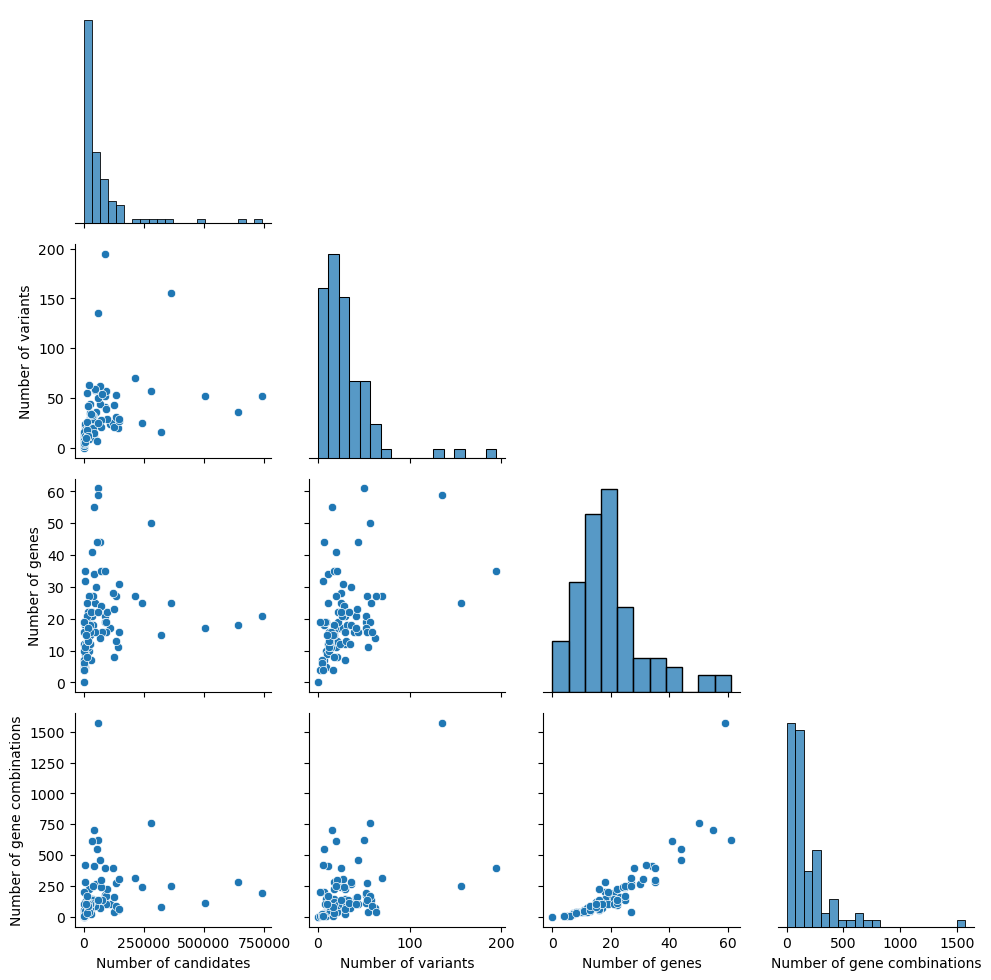

In [14]:
g = sns.PairGrid(stats.drop(columns=['pmcid']), diag_sharey=False, corner=True);
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot);

In [15]:
len(stats)

89

In [16]:
stats['Number of candidates'].sum()

6612258

# Only 256 tokens

In [7]:
from transformers import AutoTokenizer
import spacy
import scispacy
import pandas as pd
import numpy as np
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
nlp = spacy.load('en_core_sci_md')


/Users/cnachteg/miniconda3/envs/DUVEL/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [8]:
def generate_tokens(text):
    return tokenizer.tokenize(text)

def check(text):
    min_idx = np.inf
    max_idx = -np.inf
    list_sentences = list(nlp(text).sents)
    for tag in ['@GENE$', '@VARIANT$']:
            
        not_found = True
        idx = -1
        while not_found and idx < len(list_sentences) - 1:
            idx += 1
            if tag in list_sentences[idx].text:
                not_found = False
                
        if idx < min_idx:
            min_idx = idx
            
        not_found = True
        idx = len(list_sentences)
        while not_found and idx > 0:
            idx -= 1
            if tag in list_sentences[idx].text:
                not_found = False
            
        if idx > max_idx:
            max_idx = idx
        
        
    start, end = list_sentences[min_idx].start_char, list_sentences[max_idx].end_char
    text = text[start:end]
    tokens = generate_tokens(text)
    return len(tokens) <= 254

In [16]:
alambic_table = pd.DataFrame(columns=['content', 'label', 'misc'])
stats = pd.DataFrame(columns=['pmcid','num_sentences', 'num_variants','num_genes','num_combinations_genes'])
for file in os.listdir(f"{DATA_PATH}"):
    if file.endswith('_256.tsv') and file not in ('alambic_table.tsv','stats_table.tsv', 'alambic_table_256.tsv', 'stats_table_256.tsv') and file.replace('_256.tsv','') in digenic_references:
        table = pd.read_csv(f"{DATA_PATH}{file}", sep="\t")
        num_sentences = len(table)
        print(num_sentences, file)
        if num_sentences > 5000000:
            continue
        table = table[table.sentence.parallel_apply(check)]
        num_sentences = len(table)
        num_variants = len(set(table['variant1'].to_list()).union(set(table['variant2'].to_list())))
        num_genes = len(set(table['gene1'].to_list()).union(set(table['gene2'].to_list())))
        num_combinations_genes = len(table.groupby(['gene1','gene2']))
        stats = pd.concat([stats, pd.DataFrame({
            'pmcid' : [file.replace('.tsv','')],
            'num_sentences' : [num_sentences],
            'num_variants' : [num_variants],
            'num_genes' : [num_genes],
            'num_combinations_genes' : [num_combinations_genes]
        })])
        if len(table)> 0:
            table['misc'] = file.replace('.tsv','') + '/' + table.gene1 + '/' + table.gene2 + '/' + table.variant1 + '/' + table.variant2
            table.drop(columns=['gene1','gene2','variant1','variant2','pmcid'])
            table.rename(columns={'sentence':'content', 'misc': 'misc'})
            table['label'] = ''
            alambic_table = pd.concat([alambic_table,table]) 
        

5584 4470809_256.tsv
3380 5505202_256.tsv
1000 8600266_256.tsv
11083 4998745_256.tsv
4924 3426548_256.tsv
7247 5893726_256.tsv
14474 3888818_256.tsv
383 1617130_256.tsv
376 3738065_256.tsv
6438 8621929_256.tsv
377 4585455_256.tsv
9018 3842385_256.tsv
150935 4293318_256.tsv
69 7066839_256.tsv
21390 6161649_256.tsv
2655 7549550_256.tsv
4006 6338360_256.tsv
1688 3975370_256.tsv
28426 5445258_256.tsv
1632 6359299_256.tsv
2834 5426766_256.tsv
1711 6180278_256.tsv
4243 3949687_256.tsv
604 6565573_256.tsv
354 6610752_256.tsv
6136 5101836_256.tsv
452 7057083_256.tsv
2449 6567512_256.tsv
1748 5611365_256.tsv
1815 8446595_256.tsv
1067 8518634_256.tsv
4123 5765430_256.tsv
1307 5868303_256.tsv
3490 6726737_256.tsv
42062 5966321_256.tsv
14745 7224062_256.tsv
32748 8796337_256.tsv
1176 7650688_256.tsv
18390 2737700_256.tsv
5809 5973622_256.tsv
15411 5887939_256.tsv
4119 4853519_256.tsv
6914 7696449_256.tsv
0 8066997_256.tsv
144 8306687_256.tsv
2074 5587079_256.tsv
7674 7689793_256.tsv
947 6371743_25

In [17]:
alambic_table.to_csv(f"{DATA_PATH}alambic_table_256.tsv", sep="\t", index=False, na_rep="")

In [18]:
stats.to_csv(f"{DATA_PATH}stats_table_256.tsv", sep="\t", index=False, na_rep="")

In [19]:
with open(f"{DATA_PATH}duvel_256.json", "w", encoding="utf-8") as outf:
    for index, instance in alambic_table.iterrows():
        out = {"id":instance.misc, "sentence":instance.sentence}
        print(json.dumps(out, ensure_ascii=False), file=outf)

In [104]:
#stats = pd.read_csv(f"{DATA_PATH}stats_table_256.tsv", sep="\t", index_col=None)
stats.columns = ['pmcid', 'Number of candidates', 'Number of variants', 'Number of genes',
       'Number of gene combinations']

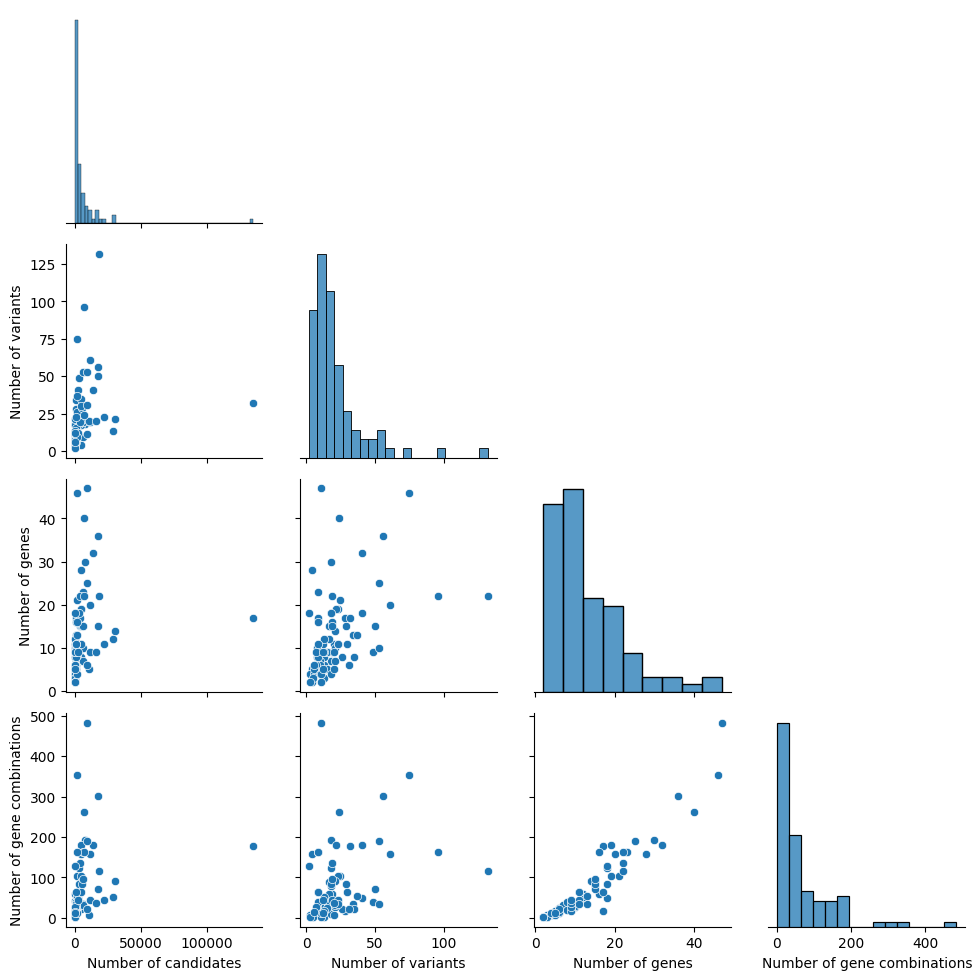

In [105]:
g = sns.PairGrid(stats.drop(columns=['pmcid']), diag_sharey=False, corner=True);
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot);

In [22]:
len(stats)

89

In [23]:
stats['Number of candidates'].sum()

739658

# Only different genes

In [7]:
data = pd.read_csv(f"{DATA_PATH}alambic_table_256.tsv", sep="\t")

In [8]:
to_ignore = []
for index, instance in data.iterrows():
    gene_1 = [item for item in instance.variant1.split(";") if "Corresponding" in item]
    gene_2 = [item for item in instance.variant2.split(";") if "Corresponding" in item]
    if (gene_1 is not None and gene_2 is not None) and gene_1 == gene_2 :
        to_ignore.append(index)

In [9]:
data = data.drop(to_ignore)

In [10]:
data.to_csv(f"{DATA_PATH}alambic_table_256_diff.tsv", sep="\t", index=False, na_rep="")

In [16]:
with open(f"{DATA_PATH}duvel_256_diff.json", "w", encoding="utf-8") as outf:
    for index, instance in data.iterrows():
        out = {"id":instance.misc.replace('_256',""), "sentence":instance.sentence}
        print(json.dumps(out, ensure_ascii=False), file=outf)

In [95]:
stats = pd.DataFrame(columns=['pmcid','num_sentences', 'num_variants','num_genes','num_combinations_genes'])
for pmcid in data.pmcid.unique():
    table = data[data.pmcid == pmcid]
    num_sentences = len(table)
    num_variants = len(set(table['variant1'].to_list()).union(set(table['variant2'].to_list())))
    num_genes = len(set(table['gene1'].to_list()).union(set(table['gene2'].to_list())))
    num_combinations_genes = len(table.groupby(['gene1','gene2']))
    stats = pd.concat([stats, pd.DataFrame({
            'pmcid' : [pmcid],
            'num_sentences' : [num_sentences],
            'num_variants' : [num_variants],
            'num_genes' : [num_genes],
            'num_combinations_genes' : [num_combinations_genes]
    })])


In [97]:
stats.to_csv(f"{DATA_PATH}stats_table_256_diff.tsv", sep="\t", index=False, na_rep="")

In [ ]:
stats.columns = ['pmcid', 'Number of candidates', 'Number of variants', 'Number of genes',
       'Number of gene combinations']
g = sns.PairGrid(stats.drop(columns=['pmcid']), diag_sharey=False, corner=True);
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot);